# Missing Data

In this notebook, we review the ___missing data___ problem. 

Why should we care about missing values?
- Missing values can be a source of errors or biases in results
- Missing values can reduce the efficiency of statistical methods

We will see that the the reason for missingness is of key importance:
- Missing Not at Random (MNAR)
- Missing at Random (MAR)
- Missing Completely at Random (MCAR)

## Example

Income is positively correlated with age.

<img src="https://raw.githubusercontent.com/sbstn-gbl/learning-from-big-data/master/source/_static/img/age-income.gif" width="800">

## Background (see lecture slides)

X represents variables that are completely observed, Y is a variable that is partly missing, Z represents the component of the causes of missingness unrelated to X and Y, and R represents the missingness.

<img src="https://raw.githubusercontent.com/sbstn-gbl/learning-from-big-data/master/source/_static/img/missingness.png" width="900">

## Imports

In [1]:
import common
import matplotlib.pyplot as plt
import numpy as np
import numpy.random
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf

%matplotlib inline

<br><br>

## Simulate data

Let's simulate some (bivariate) data, the variables are `age` and `income`.

We assume that income is a function of age (plus and intercept and a normally distributed error term that represents unobservables).

In [2]:
N = 10_000  # number of observations

# age
mu_age = 40  # mean
sd_age = 8  # standard deviation

# income (as a function of age)
a_income = 1500  # intercept
b_age = 30  # slope
scale_eps = 100  # scaling factor for the error term
mean_eps = 0  # mean of the error term
sd_eps = 3  # standard deviation of the error term

In [3]:
np.random.seed(123)

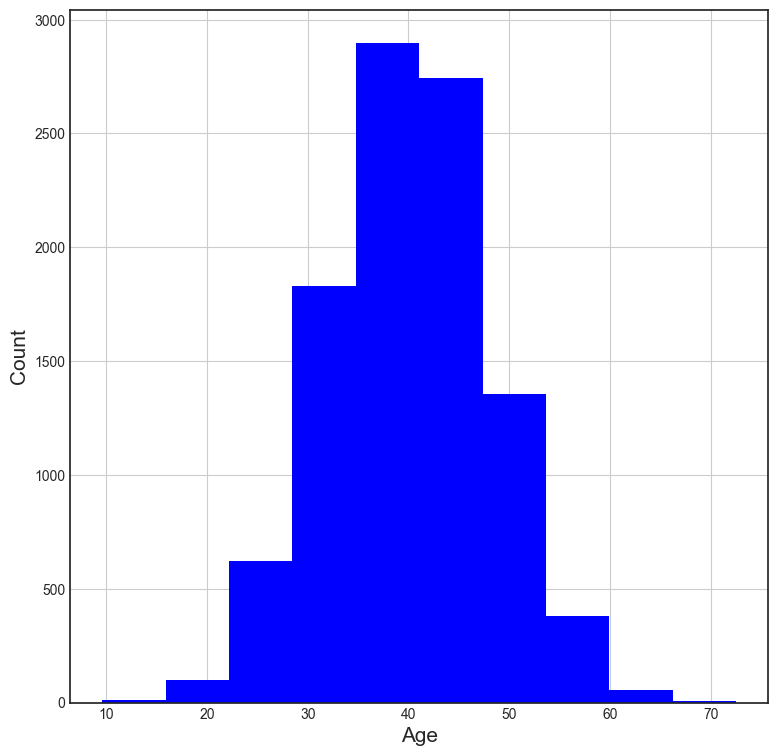

In [4]:
age = np.random.normal(40, 8, N)
plt.hist(age, color="blue")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()

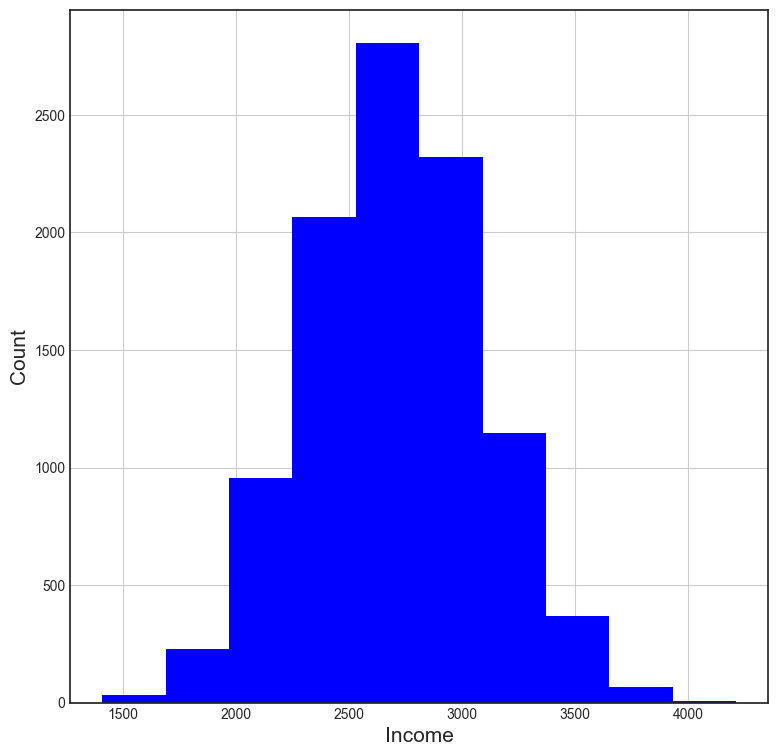

In [5]:
income = (
    a_income + b_age * age + scale_eps * np.random.normal(mean_eps, sd_eps, N)
)
plt.hist(income, color="blue")
plt.xlabel("Income")
plt.ylabel("Count")
plt.show()

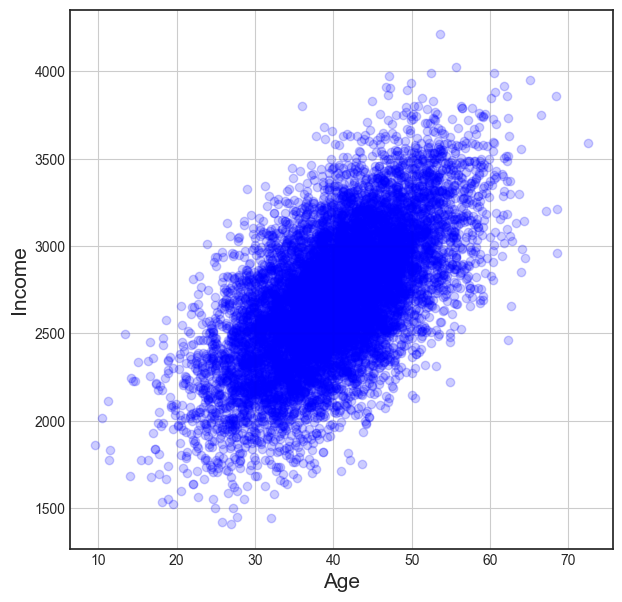

In [6]:
plt.figure(figsize=(7, 7))
_ = plt.scatter(age, income, alpha=0.2, c="blue")
plt.xlabel("Age")
plt.ylabel("Income")
plt.show()

In [7]:
# create some other variable not related to "our problem"
another_variable = np.random.uniform(0, 1, N)

In [8]:
df = pd.DataFrame(
    {
        "age": age,  # X in the lecture slides
        "income": income,  # Y in the lecture slides
        "another_variable": another_variable,  # Z in the lecture slides
    }
)

<br><br>

## Create data sets with missing observations

Below, we remove observations for income in three different ways:
1. Missingness depends on some other random variable (`Z`)
1. Missingness depends on `X`
1. Missingness depends on `Y`

We create a dataframe for each case.

In [9]:
# missingness depends on a variable not related to our problem, in other words, it is completely random
mcar_df = df.copy()
mcar_df.loc[mcar_df["another_variable"] < 0.2, "income"] = np.NaN
mcar_df["missingness"] = "mcar"

In [10]:
# missingness depends on x
mar_df = df.copy()
mar_df.loc[mcar_df["age"] > 50, "income"] = np.NaN
mar_df["missingness"] = "mar"

In [11]:
# missingness depends on y
mnar_df = df.copy()
mnar_df.loc[mnar_df["income"] < 2_500, "income"] = np.NaN
mnar_df["missingness"] = "mnar"

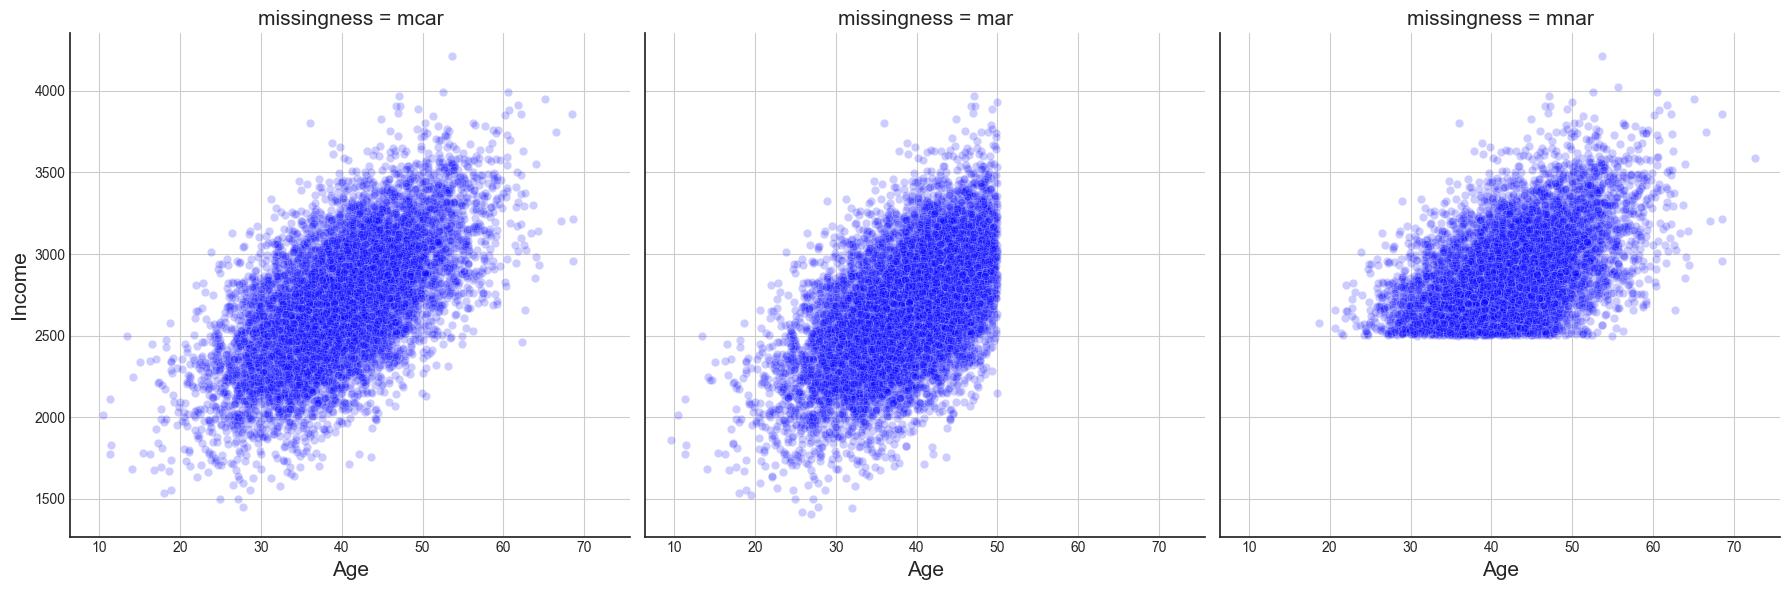

In [12]:
g = sns.FacetGrid(pd.concat([mcar_df, mar_df, mnar_df]), col="missingness", height=6)
g.map(sns.scatterplot, "age", "income", alpha=0.2, color="blue")
g.set_axis_labels("Age", "Income")
plt.show()

### Think about your expectations

Before trying things, think about different data imputation approaches. What do you think will happen when we use our different imputation strategies for the different missingness cases?

|      | <div style="width:120px">Mean</div> | <div style="width:120px">Linear Model</div> | <div style="width:120px">Linear Model + Noise</div> |
| ---- | :---: | :---: | :--: |
| MCAR | ? | ? | ? |
| MAR  | ? | ? | ? |
| MNAR | ? | ? | ? |

### Helper function

In [13]:
def impute_lm(data, kind="mean", noise=False):
    """
    This function does three things:
      1. impute missing observations: average (mean) or linear model
      2. add noise to imputed values (based on variance of error term in the linear model)
      3. plot observed and imputed values
    """

    # avoid side effects
    out = data.copy()

    # impute with mean
    if kind == "mean":
        out["income_hat"] = data["income"].mean()

    # impute with regression
    elif kind == "lm":
        model_income_age = smf.ols(
            formula="income ~ age", data=data[data["income"].notnull()]
        )
        result_model_income_age = model_income_age.fit()
        out["income_hat"] = result_model_income_age.predict(data)

    # add noise (sampled from residuals) to regression prediction
    if noise:
        out["income_hat"] += np.random.choice(
            result_model_income_age.resid, out.shape[0]
        )

    # plot
    out["imp"] = out["income"].isnull().astype(int)
    out_obs = out[out["imp"] == 0]
    plt.figure()
    # observed vaues
    plt.scatter(
        out_obs["age"], out_obs["income"], alpha=0.2, c="blue", label="Observed"
    )
    # imputed (= missing) values
    if kind != "none":
        out["income_imp_reg"] = out["income"].fillna(out["income_hat"])
        out_miss = out[out["imp"] == 1]
        plt.scatter(
            out_miss["age"],
            out_miss["income_imp_reg"],
            alpha=0.2,
            c="darkorange",
            label="Missing",
        )
    # style plot
    plt.legend(loc="upper left")
    plt.xlabel("Age")
    plt.ylabel("Income")
    plt.xlim(5, 75)
    plt.ylim(1_000, 4_500)

<br><br>

## Mising completely at random (MCAR)

### Impute with mean

Not wrong, but not clever either. We see that income is imputed correctly on average, but for high (low) age we overestimate (underestimate) income.

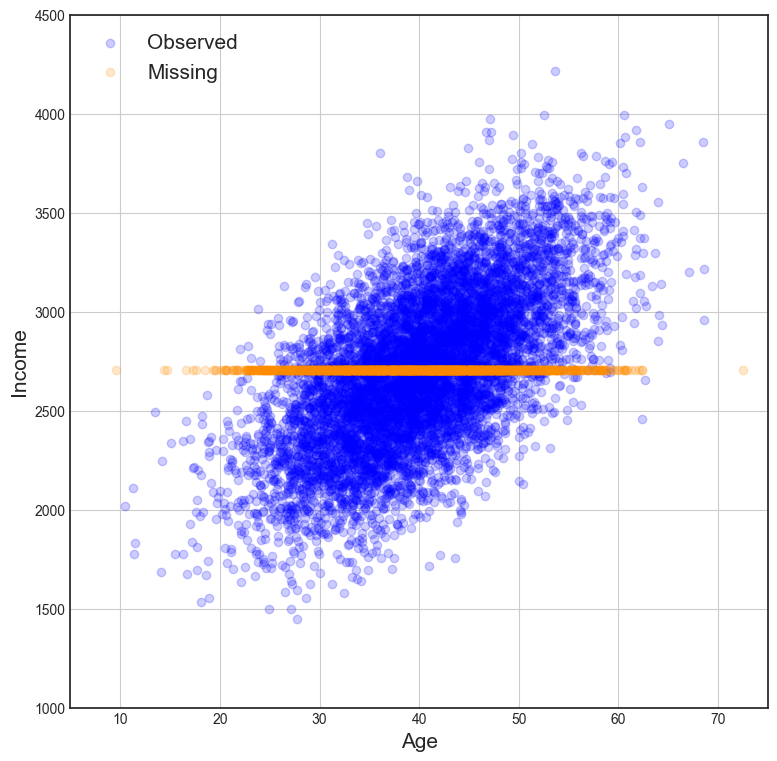

In [14]:
impute_lm(mcar_df, kind="mean", noise=False)

### Impute with regression

Much better, the linear model understand the positive correlation between income and age, so imputation works well. The linear model "filters" out noise, so the imputed values look a bit artificial. We look at this in the next approach (linear model w/ noise).

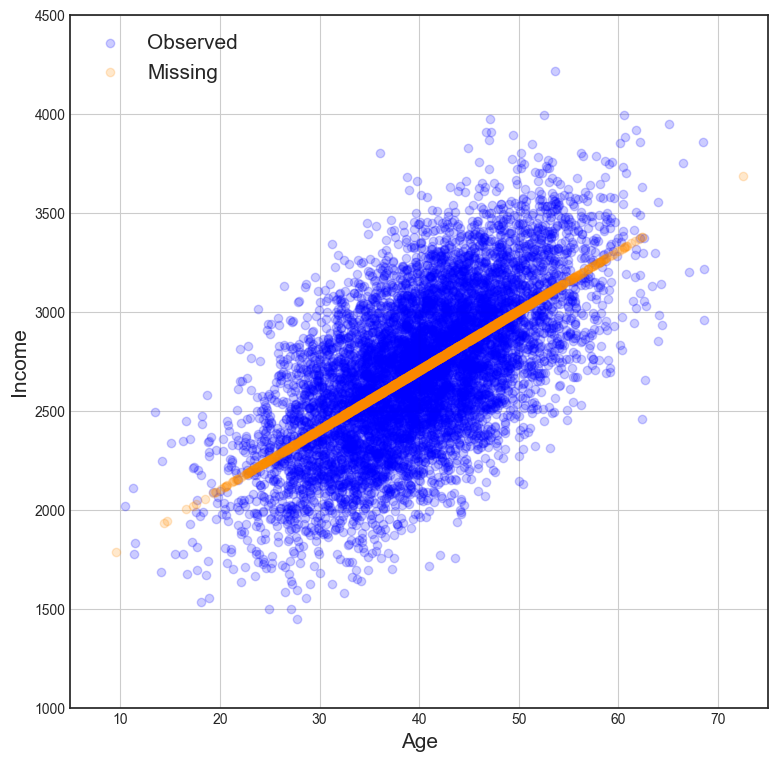

In [15]:
impute_lm(mcar_df, kind="lm", noise=False)

Impute with regression, we also add noise. This is great :)

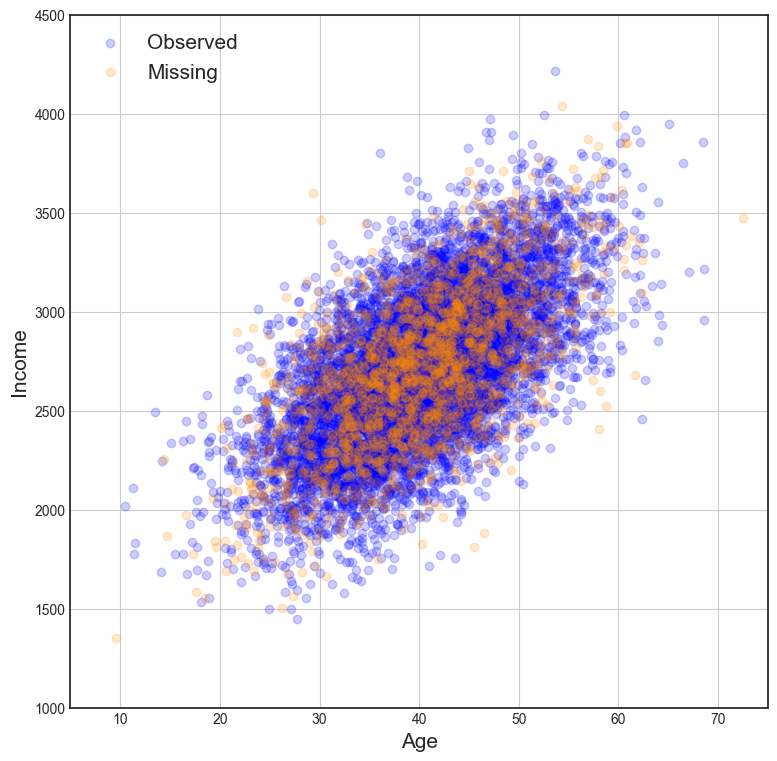

In [16]:
impute_lm(mcar_df, kind="lm", noise=True)

<br><br>

## MAR

### Impute with mean

That does not look good, values are too low! The data we see has a different average income compared to the data we do not see.

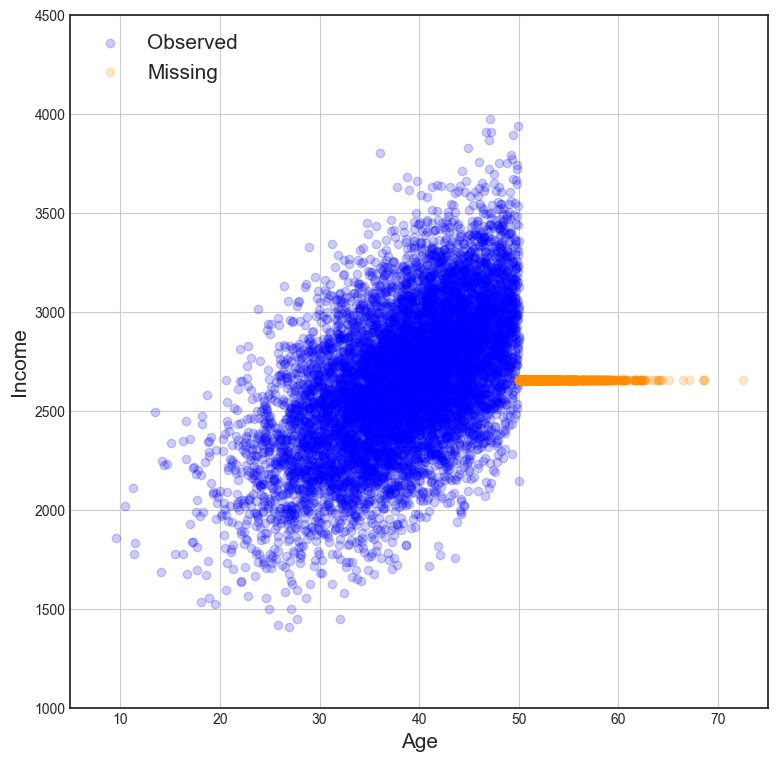

In [17]:
impute_lm(mar_df, kind="mean", noise=False)

### Impute with regression

That looks good. The linear model learn the relationship between income and age correctly from the data we see. We can extrapolate this and predict income correctly for higher age values.

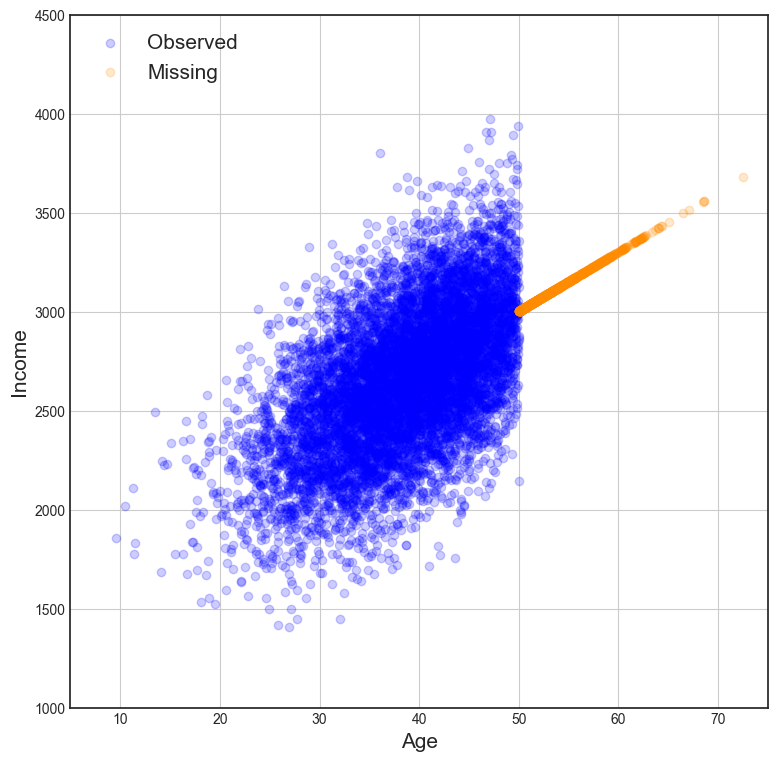

In [18]:
impute_lm(mar_df, kind="lm", noise=False)

It looks even better when we add noise :)

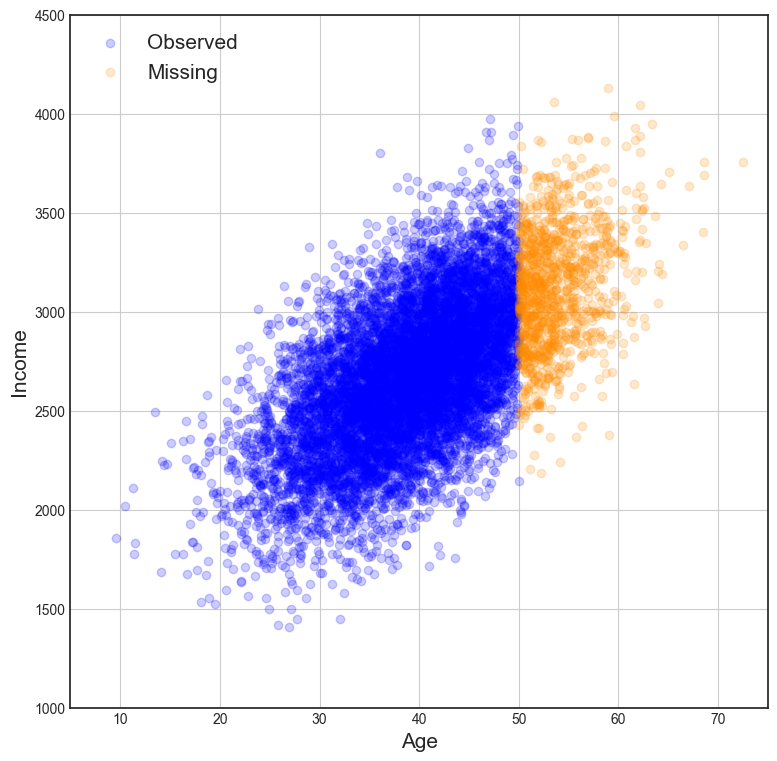

In [19]:
impute_lm(mar_df, kind="lm", noise=True)

<br><br>

## MNAR

All naïve imputation strategies fail, we need more complex methods that specifically account for the fact that the probability of missingness depends on Y (beyond the scope of this course, see econometrics courses).

### No imputation

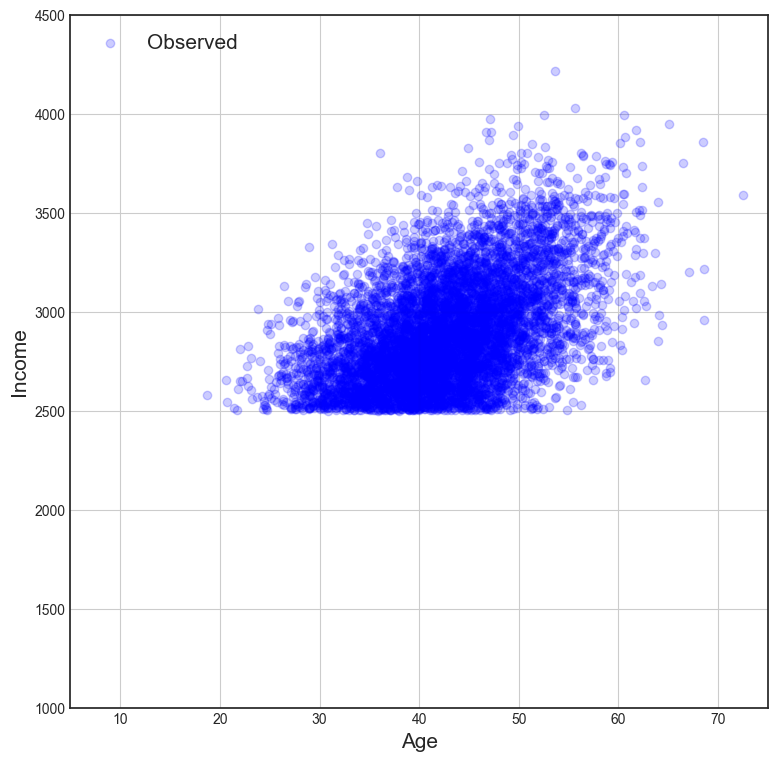

In [20]:
impute_lm(mnar_df, kind="none", noise=False)

### Impute with mean

Again, the mean in the data we see does not accurately reflect the mean in the data we do not see.

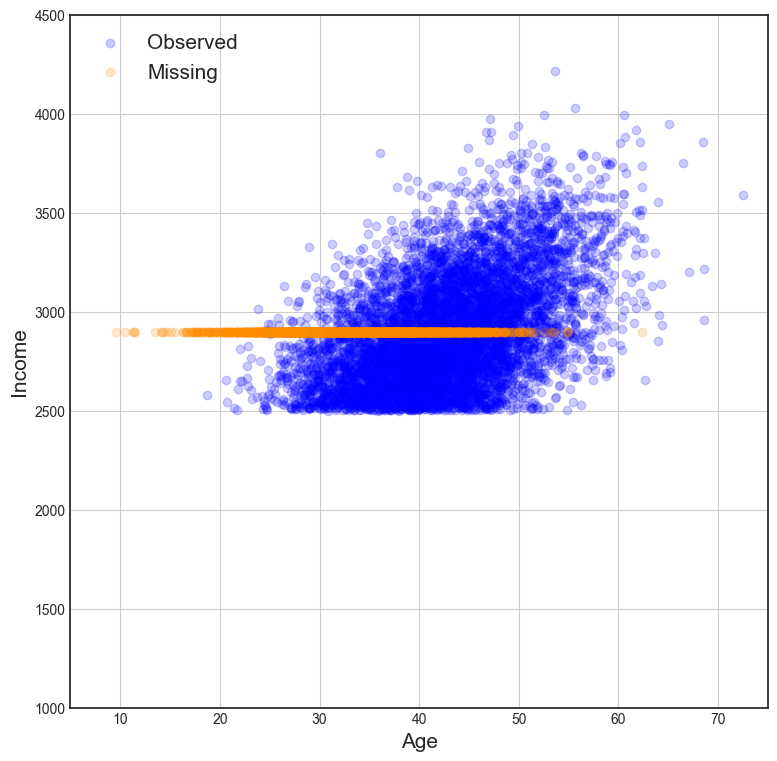

In [21]:
impute_lm(mnar_df, kind="mean", noise=False)

### Impute with regression

The dependent variable (income) is missing for low income values, so the model that learns the relationship between income and age is biased. This biases our imputed income values.

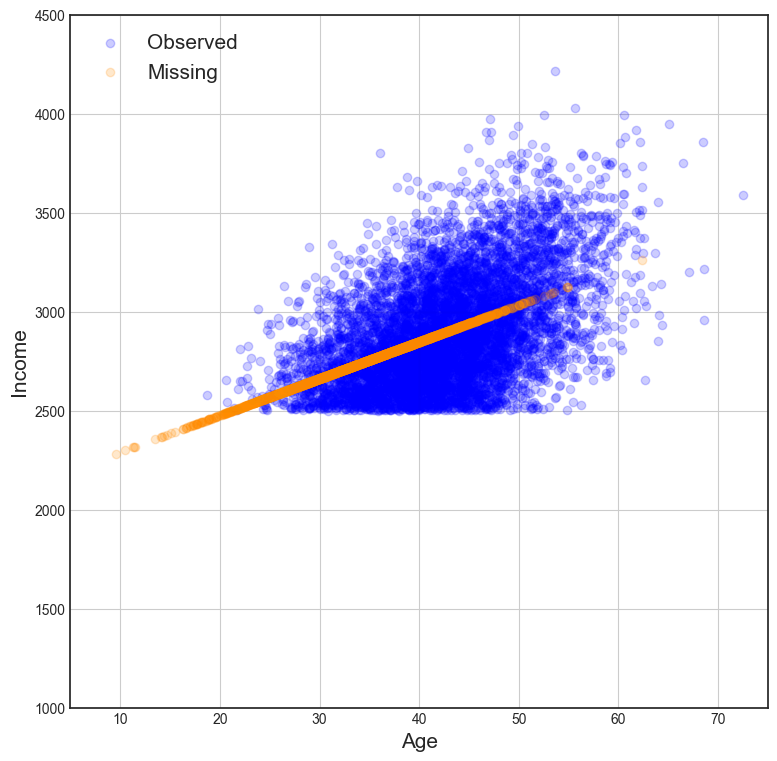

In [22]:
impute_lm(mnar_df, kind="lm", noise=False)

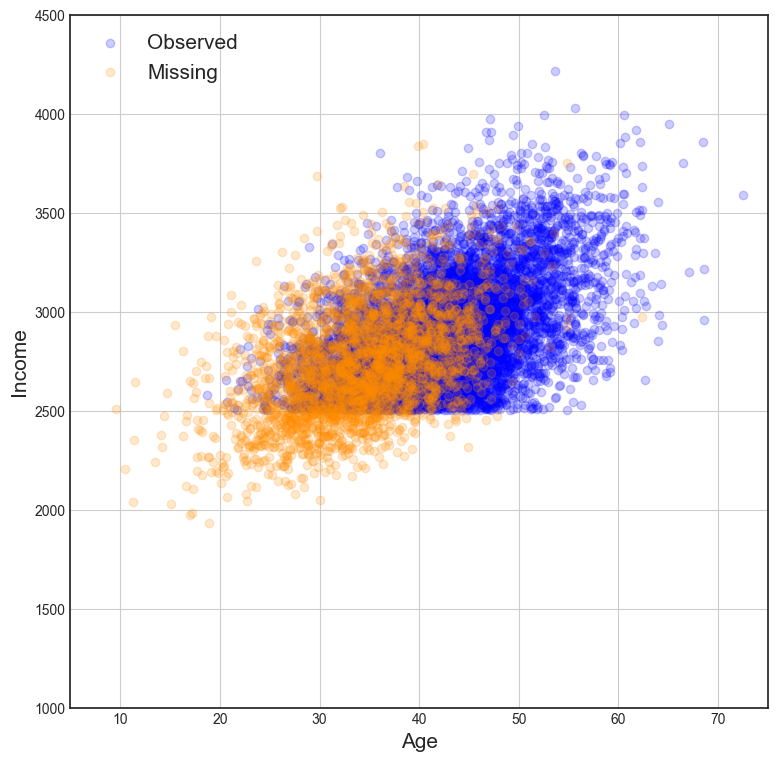

In [23]:
impute_lm(mnar_df, kind="lm", noise=True)

<br>
<br>
<b>Learning from Big Data</b> <br>
Sebastian Gabel <br>